# 0. 라이브러리 import

In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import ElectraTokenizer
from transformers import TFElectraForSequenceClassification
from transformers import TextClassificationPipeline
import wandb
from wandb.integration.keras import WandbCallback
import tensorflow_addons as tfa
from tqdm import tqdm
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13765523080129549918
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14295826432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4328415719785847860
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# 1. 데이터 확인

In [4]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
common_data_path ="~/aiffel/aiffel/dlthon/AIFFEL_DLthon/file/sampled_dataset.csv"
common_data = pd.read_csv(common_data_path)
common_data = common_data[:1000]
common_data.head()

,text,label
0,닌 된다 오카방 보니까\n면접\n열폭하는\n바보 그자체야\n인간들 만음\n난 걍 불...,일반 대화
1,그치 하지만 오빠가 아니면 내가 그오빠들을 따로 만날일은 없지\n억울하면 너도 가지...,일반 대화
2,오 생각보다 깔끔?\n나야 #@이름# ㅎ\n풉 ㅋ #@이름# 멋지다잉~\n더\n#@...,일반 대화
3,차라리 아까 20시간 간다\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,일반 대화
4,입원하나요?!\n조용하네 아직 기다리는중요ㅎㅎ\n역시 일찍일어난새가 먹이를먹네요\n...,일반 대화


In [6]:
common_data.rename(columns={'text': 'conversation', 'label': 'class'}, inplace=True)
train_data = pd.concat([train_data, common_data], ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,idx,class,conversation
0,NaN,일반 대화,#@URL#\n#@이름#아\n네\n우리가 266-511인가?\n?\n#@주소# 26...
1,NaN,일반 대화,진쫘~ #@이름#선배는 개인피티때문에 먼저 퇴근했구 나는 #@이름#님 기다리는중 #...
2,1629.0,직장 내 괴롭힘 대화,야 넌 월급루팡이야?\n죄송합니다.\n진짜 일 이따구로 할래? 짤리고 싶니?\n아닙...
3,546.0,기타 괴롭힘 대화,생긴 것 봐라. 니네 부모님은 무슨 잘못을 하셔서 이런 자식을 낳으셨냐\n뭐라는거야...
4,703.0,기타 괴롭힘 대화,야야 너 기절놀이아냐?\n그게뭔데?\n궁금하지 이리와봐 알려줄께 이렇게 목 조르면 ...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           3950 non-null   float64
 1   class         4950 non-null   object 
 2   conversation  4950 non-null   object 
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
None


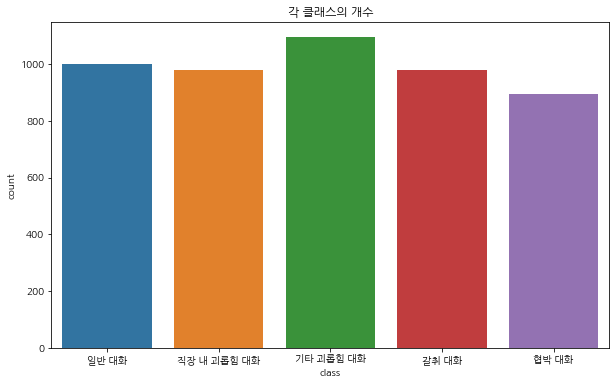

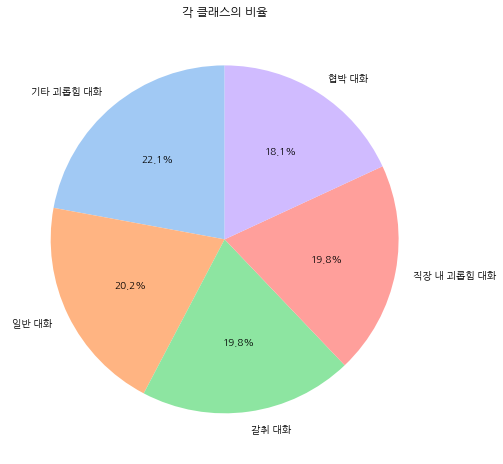

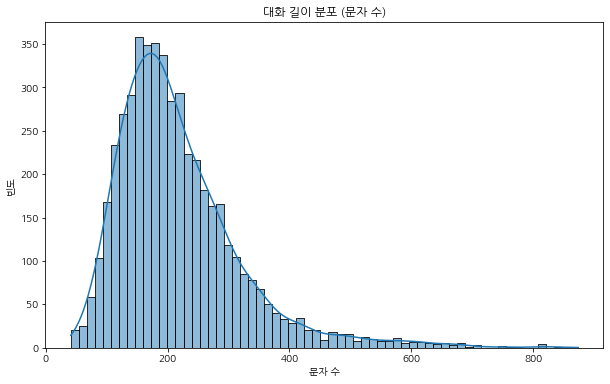

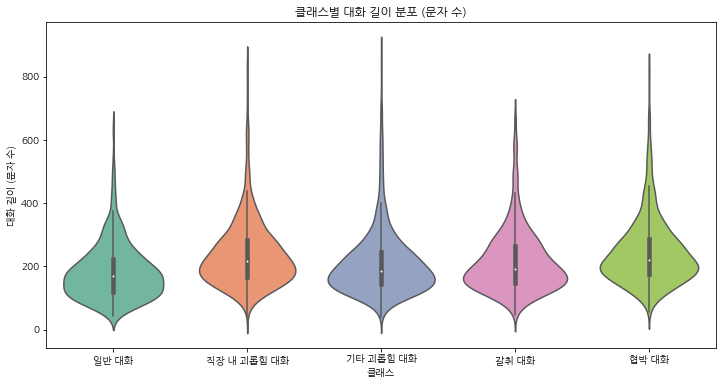

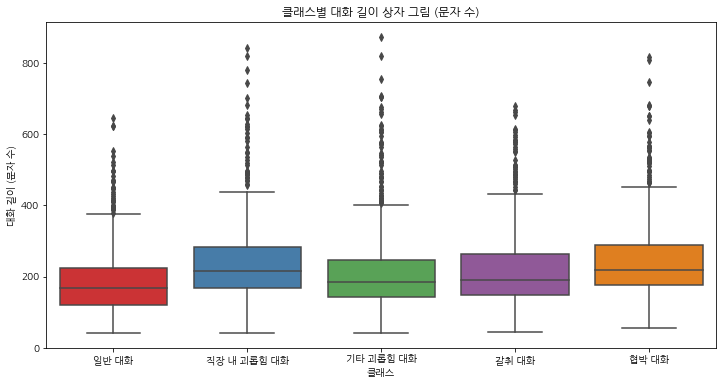

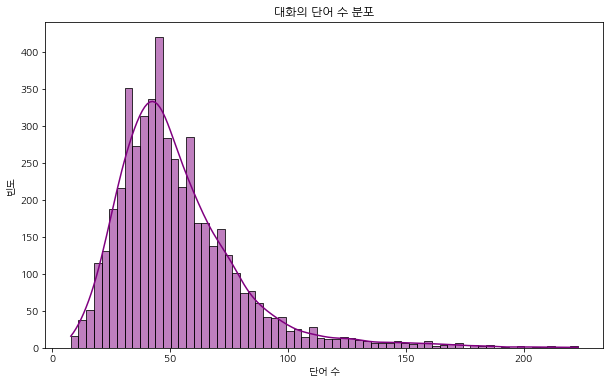

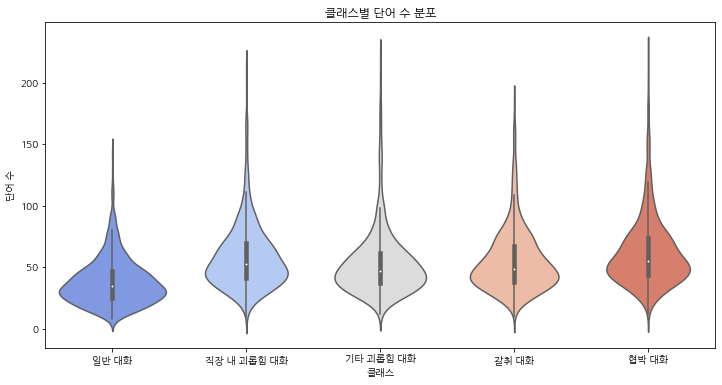

In [7]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [8]:
train_data.isnull().sum()

idx             1000
class              0
conversation       0
text_length        0
word_count         0
dtype: int64

# 2. 라벨 인코딩 & 데이터 정제

라벨 인코딩

In [9]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,NaN,2,#@URL#\n#@이름#아\n네\n우리가 266-511인가?\n?\n#@주소# 26...,165,41
1,NaN,2,진쫘~ #@이름#선배는 개인피티때문에 먼저 퇴근했구 나는 #@이름#님 기다리는중 #...,221,46
2,1629.0,3,야 넌 월급루팡이야?\n죄송합니다.\n진짜 일 이따구로 할래? 짤리고 싶니?\n아닙...,168,41
3,546.0,1,생긴 것 봐라. 니네 부모님은 무슨 잘못을 하셔서 이런 자식을 낳으셨냐\n뭐라는거야...,223,59
4,703.0,1,야야 너 기절놀이아냐?\n그게뭔데?\n궁금하지 이리와봐 알려줄께 이렇게 목 조르면 ...,118,26


In [10]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [11]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

4950

In [12]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

# 3. 데이터셋 분리

In [13]:
# input, target 리스트화
train_texts = train_data['conversation'].to_list() # Features (not-tokenized yet)
train_labels = train_data["class"].to_list() # Labels

In [14]:
x_train, x_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 3712
x_test lenght : 1238
y_train lenght : 3712
y_test lenght : 1238


In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 2598
x_val lenght : 1114
y_train lenght : 2598
y_val lenght : 1114


# 4. 사전 훈련된 모델의 토크나이저 load

In [16]:
HUGGINGFACE_MODEL_PATH = "monologg/koelectra-base-v3-discriminator"

KoELECTRA_tokenizer = ElectraTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH)

# 5. 토큰화 & 숫자 시퀀스로 변환

In [17]:
# Tokenizing
train_encodings = KoELECTRA_tokenizer(x_train, truncation=True, padding=True)
val_encodings = KoELECTRA_tokenizer(x_val, truncation=True, padding=True)
test_encodings = KoELECTRA_tokenizer(x_test, truncation=True, padding=True)

# 6. 훈련에 사용될 dataset 생성

데이터셋 객체 생성

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
))

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val
))

# 7. 사전 훈련된 모델 load

In [20]:
num_labels = len(encoder.classes_)
KoELECTRA_model = TFElectraForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True)

'''optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
KoELECTRA_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])'''

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

"optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)\nloss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)\nKoELECTRA_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])"

In [21]:
# Electra 층 동결
KoELECTRA_model.electra.trainable = False

In [22]:
KoELECTRA_model.summary()

Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
electra (TFElectraMainLayer) multiple                  112330752 
_________________________________________________________________
classifier (TFElectraClassif multiple                  594437    
Total params: 112,925,189
Trainable params: 594,437
Non-trainable params: 112,330,752
_________________________________________________________________


# 8. wandb -> 최적의 하이퍼파라미터값 찾기

In [23]:
wandb.login(key = "d5b43035f76ce84b3b50ba2ac5cd415f67f54b08")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vieisi8 (vieisi8-123). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [24]:
# 하이퍼파라미터 종류 정의
# 여기선 learning_rate, epoch만 설정
sweep_config = {
    "name": "KoELECTRA",
    "metric": {"name": "val_custom_f1score", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 1e-5,
            "max" : 9e-5
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 15
            }
                    
        }
    }

In [25]:
def save_model(model, tokenizer, MODEL_NAME, MODEL_SAVE_PATH):
    # label을 숫자형태로 encoding 진행함
    # decoding 숫자 -> label 변환
    try:
        
        id2labels = model.config.id2label
        model.config.id2label = {id : encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}

        label2ids = model.config.label2id
        model.config.label2id = {encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}
        
    except Exception as e:
        print("label이 이미 decoding 되있습니다!")

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
    else:
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

    # save tokenizer, model
    model.save_pretrained(MODEL_SAVE_PATH, save_format='tf')
    tokenizer.save_pretrained(MODEL_SAVE_PATH)

In [26]:
def f1_score_calculation(data, label, text_classifier):
    y_pred = []

    for text in tqdm(data, desc="predictive processing", total=len(data)):
        # predict
        preds_list = text_classifier(text)[0]

        sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
        preds_list = sorted_preds_list[0] 

        label_value = preds_list['label']
        y_pred.append(label_value)
        
    # label decoding 숫자 -> label 변환
    label = encoder.inverse_transform(label)
    
    # F1 점수 계산
    f1 = f1_score(label, y_pred, average='macro')  # macro는 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룸
    
    return f1

In [27]:
# tfa.metrics.F1Score을 사용하되
# y_true, y_pred shape을 통일 하기 위해 정의함
class CustomF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(CustomF1Score, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.f1 = tfa.metrics.F1Score(num_classes=num_classes, average='macro')

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes) # shape=(None, 1, 5)
        # 차원 축소하여 (None, 5)로 변경
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=1)

        
        # 로짓을 소프트맥스로 변환하여 클래스 확률로 변환
        y_pred = tf.nn.softmax(y_pred) # shape=(None, 5)
        
        return self.f1.update_state(y_true_one_hot, y_pred, sample_weight)

    def result(self):
        return self.f1.result()

    def reset_state(self):
        return self.f1.reset_state()

In [28]:
def train():
    default_config = {
        "learning_rate" : 5e-5,
        "optimizer" : "adam",
        "epoch" : 10
    }

    wandb.init(config = default_config)
    config = wandb.config

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    KoELECTRA_model.compile(optimizer = optimizer,
                  loss = loss_fn,
                  metrics = ['accuracy',CustomF1Score(num_classes=5)])
                    # metric으로 f1 score 사용

    KoELECTRA_model.fit(train_dataset.shuffle(1000).batch(14),
                        epochs = config.epoch,
                        validation_data=val_dataset.shuffle(1000).batch(14),
                        callbacks = [WandbCallback()])
    
    MODEL_NAME = "KoELECTRA-base-v3"
    MODEL_SAVE_PATH = os.path.join(os.getenv('HOME')+"/aiffel/aiffel/dlthon/", MODEL_NAME) 
    save_model(KoELECTRA_model, KoELECTRA_tokenizer, MODEL_NAME, MODEL_SAVE_PATH)
    
    # Load Fine-tuning model
    loaded_tokenizer = ElectraTokenizer.from_pretrained(MODEL_SAVE_PATH)
    loaded_model = TFElectraForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

    text_classifier = TextClassificationPipeline(
        tokenizer=loaded_tokenizer, 
        model=loaded_model, 
        framework='tf',
        return_all_scores=True
    )
    
    f1 = f1_score_calculation(x_test, y_test, text_classifier)
    
    print("Test F1 Score : ", round(f1, 4))
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test F1 Score": round(f1, 4)  # f1 score 기록
              })

In [29]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "vieisi8-123",
                       project = "KoELECTRA")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: r3l3c53h
Sweep URL: https://wandb.ai/vieisi8-123/KoELECTRA/sweeps/r3l3c53h


wandb: Agent Starting Run: fs3oiyjw with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 2.170722164089335e-05


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/7
186/186 [==============================] - 154s 761ms/step - loss: 1.5982 - accuracy: 0.2706 - custom_f1score: 0.2243 - val_loss: 1.5802 - val_accuracy: 0.2684 - val_custom_f1score: 0.1561


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 6.3s


Epoch 2/7
186/186 [==============================] - 139s 748ms/step - loss: 1.5725 - accuracy: 0.3018 - custom_f1score: 0.2164 - val_loss: 1.5518 - val_accuracy: 0.3636 - val_custom_f1score: 0.2715


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 6.3s


Epoch 3/7
186/186 [==============================] - 139s 748ms/step - loss: 1.5433 - accuracy: 0.3834 - custom_f1score: 0.3194 - val_loss: 1.5162 - val_accuracy: 0.4075 - val_custom_f1score: 0.3419


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 6.5s


Epoch 4/7
186/186 [==============================] - 139s 747ms/step - loss: 1.5037 - accuracy: 0.4230 - custom_f1score: 0.3529 - val_loss: 1.4714 - val_accuracy: 0.4399 - val_custom_f1score: 0.3828


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 6.1s


Epoch 5/7
186/186 [==============================] - 139s 747ms/step - loss: 1.4592 - accuracy: 0.4315 - custom_f1score: 0.3916 - val_loss: 1.4188 - val_accuracy: 0.4434 - val_custom_f1score: 0.3799


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 5.8s


Epoch 6/7
186/186 [==============================] - 139s 747ms/step - loss: 1.4063 - accuracy: 0.4523 - custom_f1score: 0.4075 - val_loss: 1.3664 - val_accuracy: 0.4731 - val_custom_f1score: 0.4362


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 5.7s


Epoch 7/7
186/186 [==============================] - 139s 748ms/step - loss: 1.3584 - accuracy: 0.4638 - custom_f1score: 0.4229 - val_loss: 1.3209 - val_accuracy: 0.5081 - val_custom_f1score: 0.4943


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_091052-fs3oiyjw/files/model-best)... Done. 5.8s


/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder create complete 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:55<00:00,  2.08it/s]


Test F1 Score :  0.4982


Test F1 Score,▁
accuracy,▁▂▅▇▇██
custom_f1score,▁▁▄▆▇▇█
epoch,▁▂▃▅▆▇█
loss,█▇▆▅▄▂▁
val_accuracy,▁▄▅▆▆▇█
val_custom_f1score,▁▃▅▆▆▇█
val_loss,█▇▆▅▄▂▁
Test F1 Score,0.4982
accuracy,0.46382
best_epoch,6


wandb: Agent Starting Run: b98fl8ro with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 1.3801528683855838e-05


Epoch 1/10
186/186 [==============================] - 150s 749ms/step - loss: 1.3299 - accuracy: 0.4634 - custom_f1score: 0.4286 - val_loss: 1.3015 - val_accuracy: 0.4919 - val_custom_f1score: 0.4615


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.5s


Epoch 2/10
186/186 [==============================] - 139s 747ms/step - loss: 1.3103 - accuracy: 0.4815 - custom_f1score: 0.4410 - val_loss: 1.2801 - val_accuracy: 0.5144 - val_custom_f1score: 0.4971


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 6.5s


Epoch 3/10
186/186 [==============================] - 139s 748ms/step - loss: 1.2856 - accuracy: 0.4834 - custom_f1score: 0.4537 - val_loss: 1.2630 - val_accuracy: 0.5054 - val_custom_f1score: 0.4723


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.5s


Epoch 4/10
186/186 [==============================] - 139s 747ms/step - loss: 1.2740 - accuracy: 0.4827 - custom_f1score: 0.4484 - val_loss: 1.2467 - val_accuracy: 0.5036 - val_custom_f1score: 0.4820


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 6.1s


Epoch 5/10
186/186 [==============================] - 139s 748ms/step - loss: 1.2602 - accuracy: 0.4854 - custom_f1score: 0.4602 - val_loss: 1.2315 - val_accuracy: 0.5000 - val_custom_f1score: 0.4713


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 6.4s


Epoch 6/10
186/186 [==============================] - 139s 748ms/step - loss: 1.2428 - accuracy: 0.5085 - custom_f1score: 0.4852 - val_loss: 1.2187 - val_accuracy: 0.5036 - val_custom_f1score: 0.4652


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.6s


Epoch 7/10
186/186 [==============================] - 139s 748ms/step - loss: 1.2315 - accuracy: 0.5054 - custom_f1score: 0.4758 - val_loss: 1.2111 - val_accuracy: 0.5404 - val_custom_f1score: 0.5320


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.5s


Epoch 8/10
186/186 [==============================] - 139s 748ms/step - loss: 1.2204 - accuracy: 0.5115 - custom_f1score: 0.4907 - val_loss: 1.1944 - val_accuracy: 0.5260 - val_custom_f1score: 0.5191


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.5s


Epoch 9/10
186/186 [==============================] - 139s 747ms/step - loss: 1.2107 - accuracy: 0.5081 - custom_f1score: 0.4849 - val_loss: 1.1844 - val_accuracy: 0.5305 - val_custom_f1score: 0.5262


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.7s


Epoch 10/10
186/186 [==============================] - 139s 747ms/step - loss: 1.1986 - accuracy: 0.5119 - custom_f1score: 0.4923 - val_loss: 1.1792 - val_accuracy: 0.5233 - val_custom_f1score: 0.5078


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_094106-b98fl8ro/files/model-best)... Done. 5.5s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:39<00:00,  2.14it/s]


Test F1 Score :  0.5002


Test F1 Score,▁
accuracy,▁▄▄▄▄▇▇█▇█
custom_f1score,▁▂▄▃▄▇▆█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▄▃▃▂▃█▆▇▆
val_custom_f1score,▁▅▂▃▂▁█▇▇▆
val_loss,█▇▆▅▄▃▃▂▁▁
Test F1 Score,0.5002
accuracy,0.51193
best_epoch,9


wandb: Agent Starting Run: 961ylg75 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 7.932871057639762e-05


Epoch 1/7
186/186 [==============================] - 149s 748ms/step - loss: 1.1846 - accuracy: 0.5019 - custom_f1score: 0.4891 - val_loss: 1.1492 - val_accuracy: 0.4874 - val_custom_f1score: 0.4482


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 5.5s


Epoch 2/7
186/186 [==============================] - 139s 747ms/step - loss: 1.1584 - accuracy: 0.5081 - custom_f1score: 0.4957 - val_loss: 1.1180 - val_accuracy: 0.5682 - val_custom_f1score: 0.5611


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 5.7s


Epoch 3/7
186/186 [==============================] - 139s 747ms/step - loss: 1.1396 - accuracy: 0.5246 - custom_f1score: 0.5157 - val_loss: 1.0947 - val_accuracy: 0.5781 - val_custom_f1score: 0.5738


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 5.5s


Epoch 4/7
186/186 [==============================] - 139s 747ms/step - loss: 1.1026 - accuracy: 0.5393 - custom_f1score: 0.5280 - val_loss: 1.0832 - val_accuracy: 0.5557 - val_custom_f1score: 0.5486


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 6.2s


Epoch 5/7
186/186 [==============================] - 139s 747ms/step - loss: 1.1014 - accuracy: 0.5316 - custom_f1score: 0.5244 - val_loss: 1.0479 - val_accuracy: 0.5961 - val_custom_f1score: 0.5941


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 5.6s


Epoch 6/7
186/186 [==============================] - 139s 747ms/step - loss: 1.0684 - accuracy: 0.5535 - custom_f1score: 0.5455 - val_loss: 1.0241 - val_accuracy: 0.6176 - val_custom_f1score: 0.6199


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 6.2s


Epoch 7/7
186/186 [==============================] - 139s 748ms/step - loss: 1.0713 - accuracy: 0.5466 - custom_f1score: 0.5410 - val_loss: 1.0129 - val_accuracy: 0.6095 - val_custom_f1score: 0.6126


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_101938-961ylg75/files/model-best)... Done. 6.8s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:50<00:00,  2.10it/s]


Test F1 Score :  0.608


Test F1 Score,▁
accuracy,▁▂▄▆▅█▇
custom_f1score,▁▂▄▆▅█▇
epoch,▁▂▃▅▆▇█
loss,█▆▅▃▃▁▁
val_accuracy,▁▅▆▅▇██
val_custom_f1score,▁▆▆▅▇██
val_loss,█▆▅▅▃▂▁
Test F1 Score,0.608
accuracy,0.54657
best_epoch,6


wandb: Agent Starting Run: uw9z02ou with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 4.154862768860104e-05


Epoch 1/10
186/186 [==============================] - 149s 749ms/step - loss: 1.0451 - accuracy: 0.5685 - custom_f1score: 0.5625 - val_loss: 1.0074 - val_accuracy: 0.6104 - val_custom_f1score: 0.6136


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.9s


Epoch 2/10
186/186 [==============================] - 139s 746ms/step - loss: 1.0532 - accuracy: 0.5608 - custom_f1score: 0.5556 - val_loss: 0.9906 - val_accuracy: 0.6329 - val_custom_f1score: 0.6318


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 6.8s


Epoch 3/10
186/186 [==============================] - 139s 747ms/step - loss: 1.0397 - accuracy: 0.5751 - custom_f1score: 0.5676 - val_loss: 0.9825 - val_accuracy: 0.6302 - val_custom_f1score: 0.6376


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 6.6s


Epoch 4/10
186/186 [==============================] - 139s 747ms/step - loss: 1.0318 - accuracy: 0.5724 - custom_f1score: 0.5671 - val_loss: 0.9785 - val_accuracy: 0.6346 - val_custom_f1score: 0.6329


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.8s


Epoch 5/10
186/186 [==============================] - 139s 748ms/step - loss: 1.0266 - accuracy: 0.5712 - custom_f1score: 0.5640 - val_loss: 0.9748 - val_accuracy: 0.6149 - val_custom_f1score: 0.6143


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.5s


Epoch 6/10
186/186 [==============================] - 139s 748ms/step - loss: 1.0257 - accuracy: 0.5708 - custom_f1score: 0.5665 - val_loss: 0.9737 - val_accuracy: 0.6302 - val_custom_f1score: 0.6346


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.7s


Epoch 7/10
186/186 [==============================] - 139s 748ms/step - loss: 1.0174 - accuracy: 0.5881 - custom_f1score: 0.5823 - val_loss: 0.9710 - val_accuracy: 0.6275 - val_custom_f1score: 0.6252


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.5s


Epoch 8/10
186/186 [==============================] - 139s 747ms/step - loss: 1.0069 - accuracy: 0.5812 - custom_f1score: 0.5775 - val_loss: 0.9586 - val_accuracy: 0.6293 - val_custom_f1score: 0.6231


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.7s


Epoch 9/10
186/186 [==============================] - 139s 748ms/step - loss: 1.0084 - accuracy: 0.5793 - custom_f1score: 0.5728 - val_loss: 0.9627 - val_accuracy: 0.6284 - val_custom_f1score: 0.6285
Epoch 10/10
186/186 [==============================] - 139s 748ms/step - loss: 1.0016 - accuracy: 0.5908 - custom_f1score: 0.5858 - val_loss: 0.9466 - val_accuracy: 0.6418 - val_custom_f1score: 0.6487


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_104947-uw9z02ou/files/model-best)... Done. 5.9s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [10:10<00:00,  2.03it/s]


Test F1 Score :  0.6552


Test F1 Score,▁
accuracy,▃▁▄▄▃▃▇▆▅█
custom_f1score,▃▁▄▄▃▄▇▆▅█
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇█▆▅▄▄▃▂▂▁
val_accuracy,▁▆▅▆▂▅▅▅▅█
val_custom_f1score,▁▅▆▅▁▅▃▃▄█
val_loss,█▆▅▅▄▄▄▂▃▁
Test F1 Score,0.6552
accuracy,0.59084
best_epoch,9


wandb: Agent Starting Run: tk1r8492 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 1.671173162513471e-05


Epoch 1/9
186/186 [==============================] - 150s 750ms/step - loss: 1.0044 - accuracy: 0.5885 - custom_f1score: 0.5836 - val_loss: 0.9425 - val_accuracy: 0.6373 - val_custom_f1score: 0.6360


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best)... Done. 5.8s


Epoch 2/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9860 - accuracy: 0.6001 - custom_f1score: 0.5938 - val_loss: 0.9441 - val_accuracy: 0.6409 - val_custom_f1score: 0.6407
Epoch 3/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9805 - accuracy: 0.6001 - custom_f1score: 0.5959 - val_loss: 0.9378 - val_accuracy: 0.6490 - val_custom_f1score: 0.6512


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best)... Done. 5.7s


Epoch 4/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9852 - accuracy: 0.5993 - custom_f1score: 0.5947 - val_loss: 0.9383 - val_accuracy: 0.6472 - val_custom_f1score: 0.6503
Epoch 5/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9861 - accuracy: 0.6062 - custom_f1score: 0.6003 - val_loss: 0.9329 - val_accuracy: 0.6481 - val_custom_f1score: 0.6531


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best)... Done. 6.2s


Epoch 6/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9910 - accuracy: 0.5978 - custom_f1score: 0.5941 - val_loss: 0.9326 - val_accuracy: 0.6544 - val_custom_f1score: 0.6576


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best)... Done. 6.6s


Epoch 7/9
186/186 [==============================] - 139s 749ms/step - loss: 0.9966 - accuracy: 0.5939 - custom_f1score: 0.5875 - val_loss: 0.9304 - val_accuracy: 0.6616 - val_custom_f1score: 0.6668


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_112821-tk1r8492/files/model-best)... Done. 5.5s


Epoch 8/9
186/186 [==============================] - 139s 748ms/step - loss: 0.9994 - accuracy: 0.5955 - custom_f1score: 0.5914 - val_loss: 0.9333 - val_accuracy: 0.6436 - val_custom_f1score: 0.6441
Epoch 9/9
186/186 [==============================] - 139s 749ms/step - loss: 0.9797 - accuracy: 0.5978 - custom_f1score: 0.5919 - val_loss: 0.9320 - val_accuracy: 0.6463 - val_custom_f1score: 0.6523
label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:46<00:00,  2.11it/s]


Test F1 Score :  0.6523


Test F1 Score,▁
accuracy,▁▆▆▅█▅▃▄▅
custom_f1score,▁▅▆▆█▅▃▄▄
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▁▃▃▄▆▇▁
val_accuracy,▁▂▄▄▄▆█▃▄
val_custom_f1score,▁▂▄▄▅▆█▃▅
val_loss,▇█▅▅▂▂▁▃▂
Test F1 Score,0.6523
accuracy,0.59777
best_epoch,6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ajvq1rpi with config:
wandb: 	epoch: 11
wandb: 	learning_rate: 1.803362671238695e-05


Epoch 1/11
186/186 [==============================] - 149s 748ms/step - loss: 0.9958 - accuracy: 0.6001 - custom_f1score: 0.5965 - val_loss: 0.9216 - val_accuracy: 0.6544 - val_custom_f1score: 0.6568


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best)... Done. 5.7s


Epoch 2/11
186/186 [==============================] - 139s 747ms/step - loss: 0.9747 - accuracy: 0.6051 - custom_f1score: 0.6001 - val_loss: 0.9229 - val_accuracy: 0.6652 - val_custom_f1score: 0.6692
Epoch 3/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9871 - accuracy: 0.5970 - custom_f1score: 0.5934 - val_loss: 0.9207 - val_accuracy: 0.6661 - val_custom_f1score: 0.6710


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best)... Done. 5.5s


Epoch 4/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9924 - accuracy: 0.5797 - custom_f1score: 0.5755 - val_loss: 0.9208 - val_accuracy: 0.6490 - val_custom_f1score: 0.6512
Epoch 5/11
186/186 [==============================] - 139s 749ms/step - loss: 0.9782 - accuracy: 0.6085 - custom_f1score: 0.6044 - val_loss: 0.9219 - val_accuracy: 0.6499 - val_custom_f1score: 0.6516
Epoch 6/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9838 - accuracy: 0.6032 - custom_f1score: 0.5984 - val_loss: 0.9196 - val_accuracy: 0.6490 - val_custom_f1score: 0.6505


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best)... Done. 6.5s


Epoch 7/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9832 - accuracy: 0.6070 - custom_f1score: 0.6019 - val_loss: 0.9207 - val_accuracy: 0.6634 - val_custom_f1score: 0.6685
Epoch 8/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9816 - accuracy: 0.5908 - custom_f1score: 0.5874 - val_loss: 0.9123 - val_accuracy: 0.6607 - val_custom_f1score: 0.6625


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best)... Done. 6.8s


Epoch 9/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9706 - accuracy: 0.6132 - custom_f1score: 0.6093 - val_loss: 0.9136 - val_accuracy: 0.6517 - val_custom_f1score: 0.6504
Epoch 10/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9827 - accuracy: 0.5974 - custom_f1score: 0.5930 - val_loss: 0.9159 - val_accuracy: 0.6463 - val_custom_f1score: 0.6447
Epoch 11/11
186/186 [==============================] - 139s 748ms/step - loss: 0.9854 - accuracy: 0.5920 - custom_f1score: 0.5858 - val_loss: 0.9100 - val_accuracy: 0.6625 - val_custom_f1score: 0.6654


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_120213-ajvq1rpi/files/model-best)... Done. 5.8s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:52<00:00,  2.09it/s]


Test F1 Score :  0.6598


Test F1 Score,▁
accuracy,▅▆▅▁▇▆▇▃█▅▄
custom_f1score,▅▆▅▁▇▆▆▃█▅▃
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▂▆▇▃▅▄▄▁▄▅
val_accuracy,▄██▂▂▂▇▆▃▁▇
val_custom_f1score,▄██▃▃▃▇▆▃▁▆
val_loss,▇█▇▇▇▆▇▂▃▄▁
Test F1 Score,0.6598
accuracy,0.59199
best_epoch,10


wandb: Agent Starting Run: 2l63jzw2 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 2.2156939481568268e-05


Epoch 1/6
186/186 [==============================] - 150s 751ms/step - loss: 0.9735 - accuracy: 0.5916 - custom_f1score: 0.5874 - val_loss: 0.9144 - val_accuracy: 0.6553 - val_custom_f1score: 0.6595


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best)... Done. 6.5s


Epoch 2/6
186/186 [==============================] - 139s 748ms/step - loss: 0.9719 - accuracy: 0.6016 - custom_f1score: 0.5978 - val_loss: 0.9040 - val_accuracy: 0.6616 - val_custom_f1score: 0.6662


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best)... Done. 6.5s


Epoch 3/6
186/186 [==============================] - 139s 748ms/step - loss: 0.9747 - accuracy: 0.6020 - custom_f1score: 0.5991 - val_loss: 0.9050 - val_accuracy: 0.6688 - val_custom_f1score: 0.6722
Epoch 4/6
186/186 [==============================] - 139s 748ms/step - loss: 0.9701 - accuracy: 0.6059 - custom_f1score: 0.6019 - val_loss: 0.9037 - val_accuracy: 0.6634 - val_custom_f1score: 0.6695


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best)... Done. 6.8s


Epoch 5/6
186/186 [==============================] - 139s 747ms/step - loss: 0.9704 - accuracy: 0.6082 - custom_f1score: 0.6043 - val_loss: 0.9011 - val_accuracy: 0.6634 - val_custom_f1score: 0.6663


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best)... Done. 6.0s


Epoch 6/6
186/186 [==============================] - 139s 748ms/step - loss: 0.9731 - accuracy: 0.6020 - custom_f1score: 0.5973 - val_loss: 0.9005 - val_accuracy: 0.6643 - val_custom_f1score: 0.6680


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_124043-2l63jzw2/files/model-best)... Done. 6.6s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [10:06<00:00,  2.04it/s]


Test F1 Score :  0.6571


Test F1 Score,▁
accuracy,▁▅▅▇█▅
custom_f1score,▁▅▆▇█▅
epoch,▁▂▄▅▇█
loss,▆▄█▁▂▆
val_accuracy,▁▄█▅▅▆
val_custom_f1score,▁▅█▇▅▆
val_loss,█▃▃▃▁▁
Test F1 Score,0.6571
accuracy,0.602
best_epoch,5


wandb: Agent Starting Run: nmg1q1wh with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 4.9908540930706664e-05


Epoch 1/5
186/186 [==============================] - 151s 749ms/step - loss: 0.9826 - accuracy: 0.5816 - custom_f1score: 0.5775 - val_loss: 0.9069 - val_accuracy: 0.6571 - val_custom_f1score: 0.6646


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best)... Done. 6.3s


Epoch 2/5
186/186 [==============================] - 139s 747ms/step - loss: 0.9827 - accuracy: 0.5901 - custom_f1score: 0.5865 - val_loss: 0.9005 - val_accuracy: 0.6616 - val_custom_f1score: 0.6626


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best)... Done. 6.9s


Epoch 3/5
186/186 [==============================] - 139s 748ms/step - loss: 0.9775 - accuracy: 0.6043 - custom_f1score: 0.6021 - val_loss: 0.8979 - val_accuracy: 0.6445 - val_custom_f1score: 0.6408


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_130755-nmg1q1wh/files/model-best)... Done. 6.8s


Epoch 4/5
186/186 [==============================] - 139s 748ms/step - loss: 0.9913 - accuracy: 0.5897 - custom_f1score: 0.5843 - val_loss: 0.9239 - val_accuracy: 0.6266 - val_custom_f1score: 0.6217
Epoch 5/5
186/186 [==============================] - 139s 747ms/step - loss: 0.9797 - accuracy: 0.6032 - custom_f1score: 0.6007 - val_loss: 0.9031 - val_accuracy: 0.6634 - val_custom_f1score: 0.6709
label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:54<00:00,  2.08it/s]


Test F1 Score :  0.659


Test F1 Score,▁
accuracy,▁▄█▃█
custom_f1score,▁▄█▃█
epoch,▁▃▅▆█
loss,▄▄▁█▂
val_accuracy,▇█▄▁█
val_custom_f1score,▇▇▄▁█
val_loss,▃▂▁█▂
Test F1 Score,0.659
accuracy,0.60316
best_epoch,2


wandb: Agent Starting Run: jn6a9nx0 with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 6.878370690994499e-05


Epoch 1/15
186/186 [==============================] - 152s 751ms/step - loss: 0.9655 - accuracy: 0.6066 - custom_f1score: 0.6036 - val_loss: 0.9220 - val_accuracy: 0.6302 - val_custom_f1score: 0.6247


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 6.3s


Epoch 2/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9741 - accuracy: 0.6001 - custom_f1score: 0.5977 - val_loss: 0.9009 - val_accuracy: 0.6544 - val_custom_f1score: 0.6546


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 5.8s


Epoch 3/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9685 - accuracy: 0.5962 - custom_f1score: 0.5925 - val_loss: 0.8867 - val_accuracy: 0.6670 - val_custom_f1score: 0.6689


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 5.5s


Epoch 4/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9597 - accuracy: 0.6024 - custom_f1score: 0.5985 - val_loss: 0.8922 - val_accuracy: 0.6571 - val_custom_f1score: 0.6582
Epoch 5/15
186/186 [==============================] - 139s 749ms/step - loss: 0.9548 - accuracy: 0.6120 - custom_f1score: 0.6099 - val_loss: 0.8926 - val_accuracy: 0.6499 - val_custom_f1score: 0.6485
Epoch 6/15
186/186 [==============================] - 139s 750ms/step - loss: 0.9756 - accuracy: 0.5916 - custom_f1score: 0.5884 - val_loss: 0.8850 - val_accuracy: 0.6688 - val_custom_f1score: 0.6744


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 6.8s


Epoch 7/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9804 - accuracy: 0.5874 - custom_f1score: 0.5831 - val_loss: 0.8756 - val_accuracy: 0.6732 - val_custom_f1score: 0.6777


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 5.8s


Epoch 8/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9563 - accuracy: 0.5997 - custom_f1score: 0.5968 - val_loss: 0.8811 - val_accuracy: 0.6697 - val_custom_f1score: 0.6726
Epoch 9/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9749 - accuracy: 0.6043 - custom_f1score: 0.6004 - val_loss: 0.8910 - val_accuracy: 0.6490 - val_custom_f1score: 0.6490
Epoch 10/15
186/186 [==============================] - 139s 750ms/step - loss: 0.9696 - accuracy: 0.6039 - custom_f1score: 0.5998 - val_loss: 0.8595 - val_accuracy: 0.6759 - val_custom_f1score: 0.6766


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 7.2s


Epoch 11/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9498 - accuracy: 0.6055 - custom_f1score: 0.6017 - val_loss: 0.8682 - val_accuracy: 0.6679 - val_custom_f1score: 0.6732
Epoch 12/15
186/186 [==============================] - 139s 749ms/step - loss: 0.9510 - accuracy: 0.6162 - custom_f1score: 0.6125 - val_loss: 0.8806 - val_accuracy: 0.6589 - val_custom_f1score: 0.6670
Epoch 13/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9446 - accuracy: 0.5962 - custom_f1score: 0.5918 - val_loss: 0.8718 - val_accuracy: 0.6759 - val_custom_f1score: 0.6780
Epoch 14/15
186/186 [==============================] - 139s 748ms/step - loss: 0.9635 - accuracy: 0.5982 - custom_f1score: 0.5949 - val_loss: 0.8634 - val_accuracy: 0.6679 - val_custom_f1score: 0.6704
Epoch 15/15
186/186 [==============================] - 139s 749ms/step - loss: 0.9658 - accuracy: 0.5935 - custom_f1score: 0.5903 - val_loss: 0.8564 - val_accuracy: 0.6724 - val_custom_f1score: 0.

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_133124-jn6a9nx0/files/model-best)... Done. 5.6s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [09:58<00:00,  2.07it/s]


Test F1 Score :  0.6708


Test F1 Score,▁
accuracy,▆▄▃▅▇▂▁▄▅▅▅█▃▄▂
custom_f1score,▆▄▃▅▇▂▁▄▅▅▅█▃▄▃
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▅▇▆▄▃▇█▃▇▆▂▂▁▅▅
val_accuracy,▁▅▇▅▄▇█▇▄█▇▅█▇▇
val_custom_f1score,▁▅▇▅▄██▇▄█▇▇█▇▇
val_loss,█▆▄▅▅▄▃▄▅▁▂▄▃▂▁
Test F1 Score,0.6708
accuracy,0.59353
best_epoch,14


wandb: Agent Starting Run: 1plbcmr2 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 6.728413058381426e-05


Epoch 1/10
186/186 [==============================] - 146s 734ms/step - loss: 0.9491 - accuracy: 0.5997 - custom_f1score: 0.5967 - val_loss: 0.8622 - val_accuracy: 0.6634 - val_custom_f1score: 0.6648


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best)... Done. 6.1s


Epoch 2/10
186/186 [==============================] - 137s 737ms/step - loss: 0.9520 - accuracy: 0.6059 - custom_f1score: 0.6034 - val_loss: 0.8586 - val_accuracy: 0.6759 - val_custom_f1score: 0.6755


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best)... Done. 6.8s


Epoch 3/10
186/186 [==============================] - 138s 744ms/step - loss: 0.9388 - accuracy: 0.6128 - custom_f1score: 0.6091 - val_loss: 0.8545 - val_accuracy: 0.6732 - val_custom_f1score: 0.6776


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best)... Done. 7.1s


Epoch 4/10
186/186 [==============================] - 139s 748ms/step - loss: 0.9500 - accuracy: 0.6082 - custom_f1score: 0.6054 - val_loss: 0.8682 - val_accuracy: 0.6580 - val_custom_f1score: 0.6539
Epoch 5/10
186/186 [==============================] - 139s 749ms/step - loss: 0.9336 - accuracy: 0.6147 - custom_f1score: 0.6109 - val_loss: 0.8668 - val_accuracy: 0.6679 - val_custom_f1score: 0.6723
Epoch 6/10
186/186 [==============================] - 139s 749ms/step - loss: 0.9497 - accuracy: 0.5985 - custom_f1score: 0.5954 - val_loss: 0.8559 - val_accuracy: 0.6732 - val_custom_f1score: 0.6756
Epoch 7/10
186/186 [==============================] - 139s 750ms/step - loss: 0.9379 - accuracy: 0.6174 - custom_f1score: 0.6148 - val_loss: 0.8781 - val_accuracy: 0.6768 - val_custom_f1score: 0.6837
Epoch 8/10
186/186 [==============================] - 139s 751ms/step - loss: 0.9500 - accuracy: 0.6055 - custom_f1score: 0.6021 - val_loss: 0.8623 - val_accuracy: 0.6750 - val_custom_f1score: 0.6790


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241006_142022-1plbcmr2/files/model-best)... Done. 6.1s


label이 이미 decoding 되있습니다!
/aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3 -- Folder already exists 



All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/KoELECTRA-base-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
predictive processing: 100%|██████████| 1238/1238 [10:04<00:00,  2.05it/s]


Test F1 Score :  0.6572


Test F1 Score,▁
accuracy,▁▄▆▅▇▁█▄▃▁
custom_f1score,▂▄▆▅▇▁█▄▃▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇█▄▇▂▇▃▇▁█
val_accuracy,▃█▇▁▅▇█▇▃▅
val_custom_f1score,▄▆▇▁▅▆█▇▃▄
val_loss,▄▃▂▅▅▂█▄▄▁
Test F1 Score,0.6572
accuracy,0.59892
best_epoch,9


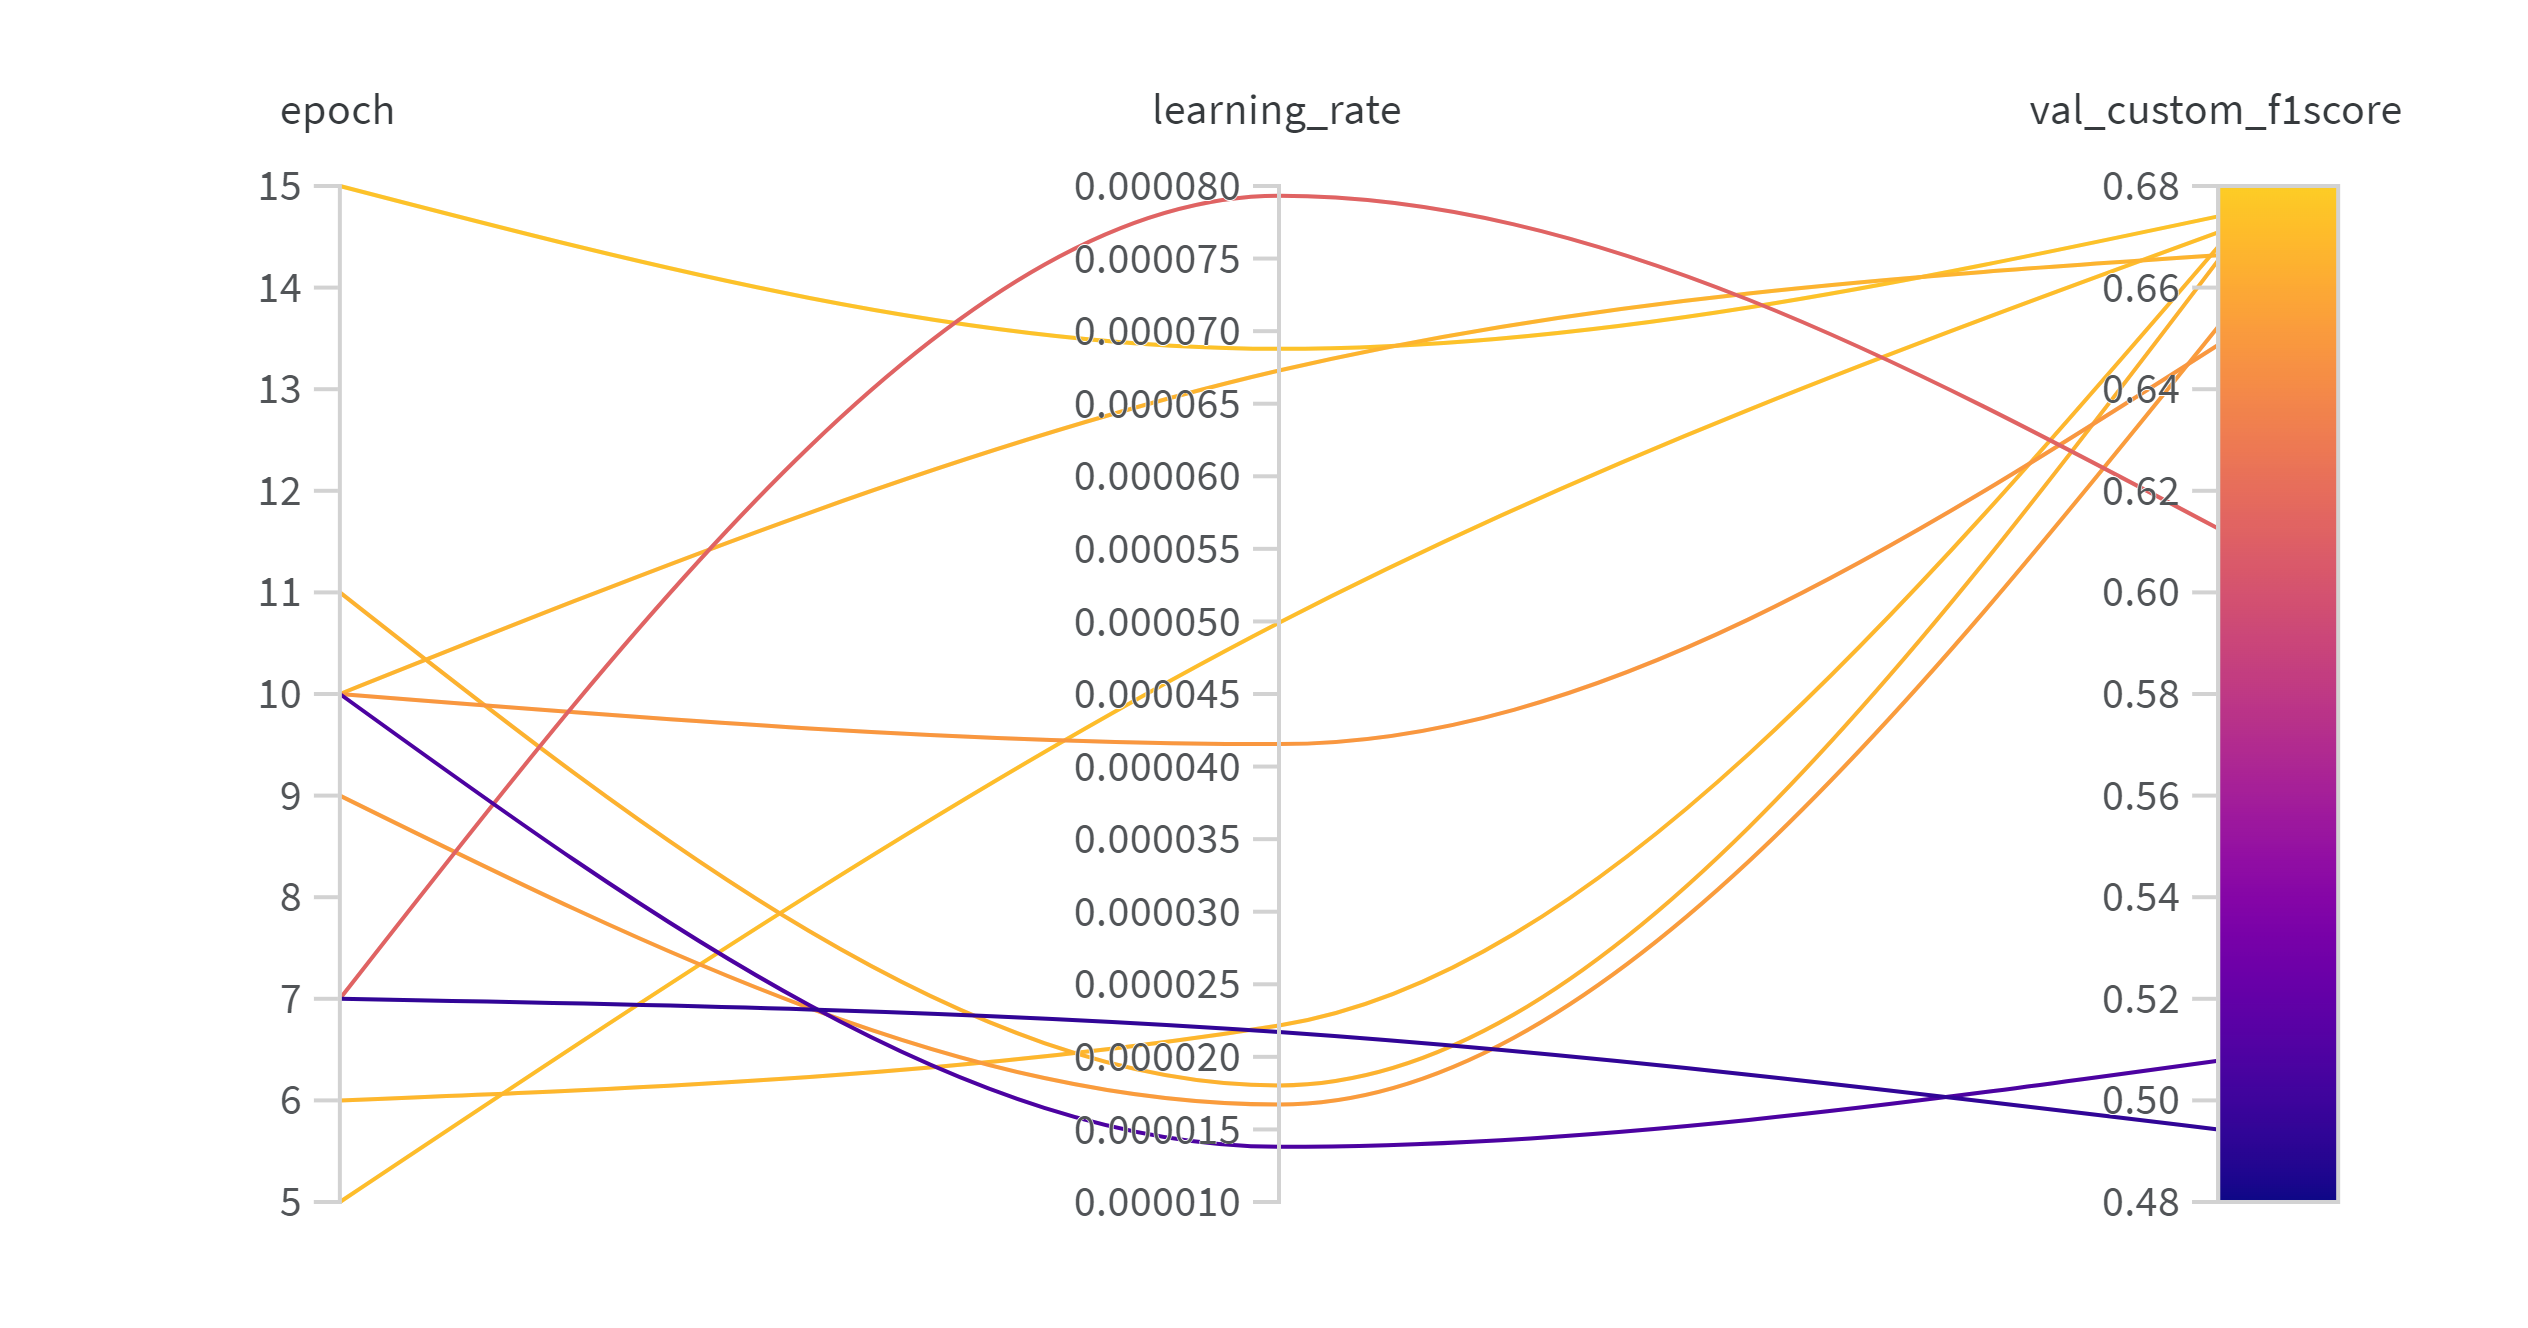

- learning_rate -> 0.000068784
- epoch -> 15